In [ ]:
!pip install mendelai-brat-parser

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from google.colab import files
import zipfile
import tarfile
import glob

import regex as re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import gensim
import gensim.downloader as api

from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
from brat_parser import get_entities_relations_attributes_groups

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, Input
import tensorflow as tf

In [ ]:
# Import the rotten imdb dataset.

uploaded = files.upload()

Saving ArgumentAnnotatedEssays-2.0.zip to ArgumentAnnotatedEssays-2.0.zip


# **Sab and Gurevych dataset**

In [ ]:
# Import the Stab and Gurevych dataset.

uploaded = files.upload()

Saving rotten_imdb.tar.gz to rotten_imdb.tar.gz


In [ ]:
# Function to extract zip file.
# Takes in input the path to the zip file (path_zip) and the one to store the destination directory (path_destination)

def extract_zip(path_zip,path_destination):
  with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(path_destination)

In [ ]:
# Extract zip file (two zip files one inside the other)

extract_zip('ArgumentAnnotatedEssays-2.0.zip','ArgumentAnnotatedEssays-2.0')

extract_zip('ArgumentAnnotatedEssays-2.0/ArgumentAnnotatedEssays-2.0/brat-project-final.zip','ArgumentAnnotatedEssays')

In [ ]:
# List of text files of the essays in the dataset
txt_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.txt"))

# List of annotated files of the essays in the dataset
ann_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.ann"))

In [ ]:
# Transfor the ann files into four dictionaries
ann_disctionaries=[get_entities_relations_attributes_groups(file) for file in ann_files]

# Transform the first dictionary (entities) obtained from each ann file into a dataset
essay_ann_datasets = [pd.DataFrame.from_dict(entities, orient='index') for entities,_,_,_ in ann_disctionaries]

# Add a coloumn into the dataset that identifies the document
for i in range(len(essay_ann_datasets)):
  essay_ann_datasets[i].insert(0,'doc_id',i)

# Create a common dataset
Essay_ann_dataset = pd.concat(essay_ann_datasets)

In [ ]:
# Sobstitue the values in the "span" feature (substitute each tuple with its first inner tuple)
for i in range(len(Essay_ann_dataset.index)):
  Essay_ann_dataset['span'][i]=Essay_ann_dataset['span'][i][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Standar separation and tokenization used in all the works**

In [ ]:
# List of texts of the essays
files_text=[open(file).read() for file in txt_files]

In [ ]:
# Get the start and finish points of each argumentative section of each of the text.
# Also get the type of each argumentative section.
# This points are indicated in the "span" coloumn of the Dataframe of the annotation.

sorted_span=[sorted(list(Essay_ann_dataset.loc[Essay_ann_dataset['doc_id'] == i,['span','type']].values), key=lambda element: (element[0][0]) ) for i in range(len(ann_files))]

In [ ]:
sorted_span[0]

[array([(503, 575), 'MajorClaim'], dtype=object),
 array([(591, 714), 'Claim'], dtype=object),
 array([(716, 851), 'Premise'], dtype=object),
 array([(853, 1086), 'Premise'], dtype=object),
 array([(1088, 1191), 'Premise'], dtype=object),
 array([(1212, 1301), 'Premise'], dtype=object),
 array([(1332, 1376), 'Claim'], dtype=object),
 array([(1387, 1492), 'Premise'], dtype=object),
 array([(1549, 1846), 'Premise'], dtype=object),
 array([(1927, 1992), 'Claim'], dtype=object),
 array([(2154, 2231), 'MajorClaim'], dtype=object)]

In [ ]:
# Tranform the couples of points ((start,end) of each section) to a list (separator of different section).

span_points=[]

for i in range(len(sorted_span)):
  list_points=[sep for sub in sorted_span[i] for sep in sub[0]]
  # Insert starting point of the text
  list_points.insert(0,0)
  list_points.append(len(files_text[i]))
  span_points.append(list_points)

In [ ]:
span_points[0]

[0,
 503,
 575,
 591,
 714,
 716,
 851,
 853,
 1086,
 1088,
 1191,
 1212,
 1301,
 1332,
 1376,
 1387,
 1492,
 1549,
 1846,
 1927,
 1992,
 2154,
 2231,
 2232]

In [ ]:
# Separate the texts at the point indicated for the different sections

split_text=[]

for z in range(len(files_text)):
  split_text.append([files_text[z][i: j] for i, j in zip(span_points[z], span_points[z][1:])])

In [ ]:
split_text[0][0:10]

["Should students be taught to compete or to cooperate?\n\nIt is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that ",
 'we should attach more importance to cooperation during primary education',
 '.\nFirst of all, ',
 'through cooperation, children can learn about interpersonal skills which are significant in the future life of all students',
 '. ',
 'What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others',
 '. ',
 'During the process of cooperation, children can learn about how to listen to opinions of others, how to com

In [ ]:
# Get the list of the words of each essay.

X_essay_word_list=[]

for i in range(len(split_text)):
  
  essay_word_list=[]

  # next_type is the next position still not considered in the list of argumentative sections of the essay examined.
  next_type=0

  # Remove title from essay considered (splitted_text)
  no_title=[re.sub(r".*\n\n","",text) for text in split_text[i]]

  no_title=[re.sub(r"\n"," | ",text) for text in no_title]

  for section in no_title:

    # Divide the text into token.
    seq=nltk.word_tokenize(section.lower())

    essay_word_list+=seq

  X_essay_word_list.append(essay_word_list)

In [ ]:
# Get the list of all the sentences words.

sentence_list=[]   

for essay_id in range(len(X_essay_word_list)):
  sentence=[]

  for word_id in range(len(X_essay_word_list[essay_id])):
    
    word=X_essay_word_list[essay_id][word_id]
          
    if not ( word=="|" or word=="." ):
      # Add to the sentence every word that is not a simple \n.
      sentence.append(word)

    # . is the end of the sentence.       
    if word in [".","?","!"] and bool(sentence):
      sentence_list.append(sentence)
      sentence=[]

  if bool(sentence):
    sentence_list.append(sentence)

In [ ]:
len(sentence_list)

6738

In [ ]:
# Get the maximum lenght of the argumentative sections of the essays.

text_len = [len(text) for text in sentence_list]
MAX_LEN_STAB_GUREV= max(text_len)
print("Max lenght of sentences: {}".format(MAX_LEN_STAB_GUREV))

Max lenght of sentences: 72


# **IMBD dataset learning**

In [ ]:
# Extract tar.gz file
tar = tarfile.open('rotten_imdb.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [ ]:
subjective=open('plot.tok.gt9.5000',encoding='latin-1').read()
objective=open('quote.tok.gt9.5000',encoding='latin-1').read()

In [ ]:
# The two files contain 5000 sentences each which are divided by the \n character.
subjective=subjective.split('\n')
objective=objective.split('\n')

In [ ]:
# Both files have an additional void line.
subjective=subjective[:-1]
objective=objective[:-1]

In [ ]:
len(objective)

5000

In [ ]:
list_sentences=subjective+objective

In [ ]:
# The labels are 1 (subjective) for the first 5000 sentences and 0 (objective) for the 
# remaining 5000.
list_labels= [1] * 5000 + [0] * 5000

In [ ]:
list_labels[4990:5010]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Transform the sentences in the sequences of their words.
X_sub_obj=[nltk.word_tokenize(sentence) for sentence in list_sentences]

In [ ]:
Y_sub_obj=np.array(list_labels)

## **Word2vec and one-hot-encoding**

In [ ]:
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
# Load Google Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)  

In [ ]:
# Get the maximum lenght of the sentences.

text_len = [len(text) for text in X_sub_obj]
MAX_LEN_sub_obj= max(text_len)
MAX_LEN_sub_obj= max(MAX_LEN_sub_obj,MAX_LEN_STAB_GUREV)
print("Max lenght of sentences: {}".format(MAX_LEN_sub_obj))

Max lenght of sentences: 122


In [ ]:
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(X_sub_obj)
X_sentences_sub_obj = text_tokenizer.texts_to_sequences(X_sub_obj)
X_sentences_sub_obj = pad_sequences(X_sentences_sub_obj, maxlen=MAX_LEN_sub_obj, padding="pre")

In [ ]:
# Each word in the Word2vec model used is embedded trough a vector of size 300
EMBEDDING_SIZE_sub_obj = 300

# Size of the vocabulary used
VOCABULARY_SIZE_sub_obj = len(text_tokenizer.word_index) + 1

# Create an empty embedding matix
embedding_weights_sub_obj = np.zeros((VOCABULARY_SIZE_sub_obj, EMBEDDING_SIZE_sub_obj))

# Create a word to index dictionary mapping
word2id_sub_obj = text_tokenizer.word_index

# Copy vectors from word2vec model to the words present in corpus
for word, index in word2id_sub_obj.items():
    try:
        embedding_weights_sub_obj[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

Output streaming troncato alle ultime 5000 righe.
227
252
nunn
landon
year-old
13
wwii
anakin
free-spirited
majidi
<
goldmember
zellweger
tiz
igby
100
heavy-handed
first-time
stand-up
well-made
tongue-in-cheek
solondz
pinocchio
haynes
well-intentioned
amitabh
12-year-old
spielrein
mcnamara
cockettes
esther
frodo
witherspoon
high-tech
1980
paradiso
rlich
otte
regulus
1950
b-movie
obi-wan
18
'a
17
tobias
1970s
isabelle
jaglom
nickleby
50
hannibal
light-hearted
tarantino
action-packed
mothman
101
haneke
waydowntown
self-conscious
nachtwey
brosnan
carvey
rohmer
good-natured
self-deprecating
sayles
wendigo
low-key
ramsay
kung-fu
komal
danang
chomsky
'60s
hiller
good-hearted
juwanna
philippa
would-be
superfag
huston
otis
mordor
aragorn
self-destructive
working-class
amerika
mateo
akash
harbour
day-to-day
trasha
dogville
werner
chep
fett
lapd
genevieve
ancanar
affleck
amidala
johnathan
alexi
prosit
devlin
t-mon
high-profile
davey
duvall
brookdale
eastwood
ex-con
kilmer
barrillo
follow-up
para

## **RNN**

In [ ]:
# Split between test and train set

# Create a statified holdouts generator that split the data in folds of dimension equals to 0.15 the orignal dataset size,
# using one of them as test set, and repeating the split 4 times.
# The folds created will mantain the original percentage of samples for each class.

number_of_splits = 4

holdouts_generator = ShuffleSplit(n_splits=number_of_splits,test_size=0.15)

In [ ]:
# Create and train recurrent models

# Bidirectional LSTM model

def train_BLSTM(X_train:np.ndarray, Y_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_sub_obj,))

  model = Embedding(input_dim=VOCABULARY_SIZE_sub_obj, output_dim=EMBEDDING_SIZE_sub_obj, input_length=MAX_LEN_sub_obj, weights= [embedding_weights_sub_obj], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(64))(model)
  model = Dropout(0.1)(model)
  model = Dense(16, activation='relu')(model)
  output = Dense(1, activation='sigmoid')(model)

  final_model=Model(input,output)

  final_model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
    
  training_results= final_model.fit(X_train, Y_train, batch_size=64, epochs=30, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=3),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return final_model

holdouts: 0


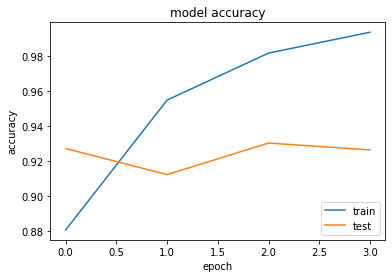

holdouts: 1


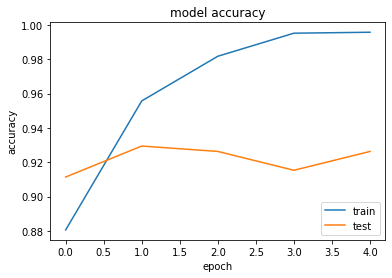

holdouts: 2


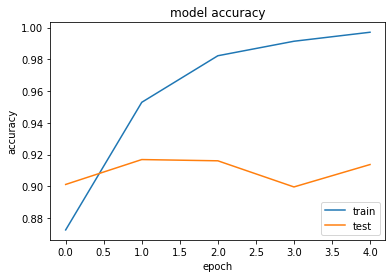

holdouts: 3


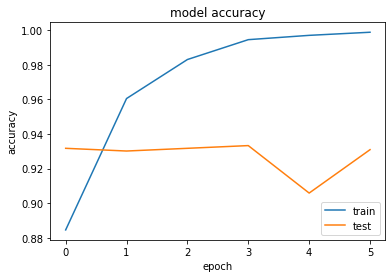

              precision    recall  f1-score   support

   Objective       0.92      0.92      0.92      2940
  Subjective       0.93      0.93      0.93      3060

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



In [ ]:
target_names=['Objective','Subjective']

y_pred=[]
y_true=[]

# Start the main loop, iterating through the holdouts.
for holdout_number, (train_indices, test_indices) in enumerate(holdouts_generator.split(X_sentences_sub_obj, Y_sub_obj)):

  X_train, X_test = X_sentences_sub_obj[train_indices], X_sentences_sub_obj[test_indices]
  Y_train, Y_test = Y_sub_obj[train_indices], Y_sub_obj[test_indices]

  # Print the number of the current holdouts considered.
  print("holdouts: {}".format(holdout_number))

  model=train_BLSTM(X_train,Y_train)

  # Transform probabilities predicted in the most probable value (0 or 1).
  y_pred_temp=model.predict(X_test).tolist()
  for input in y_pred_temp:
      y_pred.append(round(input[0]))
  y_true+=Y_test.tolist()

# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names))   

## **Final model**

In [ ]:
from sklearn.model_selection import train_test_split

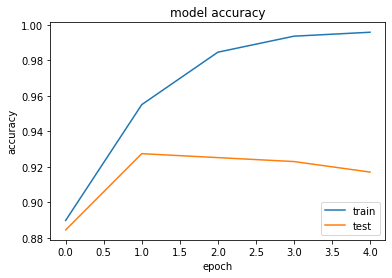

              precision    recall  f1-score   support

   Objective       0.89      0.94      0.91       477
  Subjective       0.94      0.90      0.92       523

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [ ]:
# Create the model to predict the subjectivity of sentence from the Stab and Gurevych argumentation mining dataset (2017).
# Split between test and train set.

y_pred=[]
y_true=[]

X_train, X_test, Y_train, Y_test = train_test_split(X_sentences_sub_obj, Y_sub_obj, test_size=0.1, random_state=22)

model=train_BLSTM(X_train,Y_train)

# Transform probabilities predicted in the most probable value (0 or 1).
y_pred_temp=model.predict(X_test).tolist()
for input in y_pred_temp:
    y_pred.append(round(input[0]))
y_true+=Y_test.tolist()

# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names))   

**Prediction**

In [ ]:
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(sentence_list)
X = text_tokenizer.texts_to_sequences(sentence_list)
X = pad_sequences(X, maxlen=MAX_LEN_sub_obj, padding="pre")

In [ ]:
len(X)

6738

In [ ]:
y_pred=[]

# Store the probabilities predicted.
y_pred_temp=model.predict(X).tolist()
for input in y_pred_temp:
    y_pred.append(round(input[0],5))

In [ ]:
len(y_pred)

6738

In [ ]:
f = open("subj_obj.txt", "a")
for prediction in y_pred:
  f.write("{}--".format(prediction))
f.close()

In [ ]:
# Read the file
scores_text=open("subj_obj.txt").read()

In [ ]:
subjectivity_scores=scores_text.split('--')

In [ ]:
len(subjectivity_scores)

6739

In [ ]:
subjectivity_scores[:10]

['0.99925',
 '0.00466',
 '0.59203',
 '0.02907',
 '0.00154',
 '0.3258',
 '0.00074',
 '0.80575',
 '0.21887',
 '0.99908']